<a href="https://colab.research.google.com/github/yxmauw/GA_Capstone/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="http://imgur.com/1ZcRyrc.png" width="70" height="70" align="left" style="margin: 20px"> 
 # Capstone: Glaucoma detection using Fundoscopy images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

In [2]:
# upload files to working directory each runtime
!git clone https://github.com/yxmauw/GA_Capstone.git # has to be public repository

Cloning into 'GA_Capstone'...
remote: Enumerating objects: 793, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 793 (delta 77), reused 116 (delta 66), pack-reused 660
Receiving objects: 100% (793/793), 202.90 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (77/77), done.
Checking out files: 100% (655/655), done.


In [3]:
all_labels = pd.read_csv('./GA_Capstone/glaucoma_labels.csv') # this works which is weird
all_labels.head(3)

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0


In [4]:
# explore counts
all_labels['Glaucoma'].value_counts()
# 482 negative, 168 positive for glaucoma (contains both train, validation images)
# unbalanced data
# total 650 images

0    482
1    168
Name: Glaucoma, dtype: int64

In [5]:
import fnmatch
import os

# image files count
train_g_negative_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Negative'), '*.jpg'))
train_g_positive_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive'), '*.jpg'))
test_g_negative_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Validation/Glaucoma_Negative'), '*.jpg'))
test_g_positive_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Validation/Glaucoma_Positive'), '*.jpg'))
total_image_count = train_g_negative_count + train_g_positive_count + \
                    test_g_negative_count + test_g_positive_count
# print count
print('---Train images---')
print('Glaucoma Negative:', train_g_negative_count)
print('Glaucoma Positive:', train_g_positive_count)
print()
print('---Validation iamges---')
print('Glaucoma Negative:', test_g_negative_count)
print('Glaucoma Positive:', test_g_positive_count)
print()
print('---Total image count---')
print(total_image_count)

---Train images---
Glaucoma Negative: 386
Glaucoma Positive: 134

---Validation iamges---
Glaucoma Negative: 96
Glaucoma Positive: 34

---Total image count---
650


In [6]:
# load example image
from PIL import Image 
im = Image.open('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
# summarize some details about the image
print(im.format)
print(im.mode)
print(im.size)

pixels = np.asarray(im)
print(pixels[0])
print(pixels.shape) # channel last

JPEG
RGB
(3072, 2048)
[[1 3 0]
 [1 3 0]
 [1 3 0]
 ...
 [1 3 0]
 [1 3 0]
 [1 3 0]]
(2048, 3072, 3)


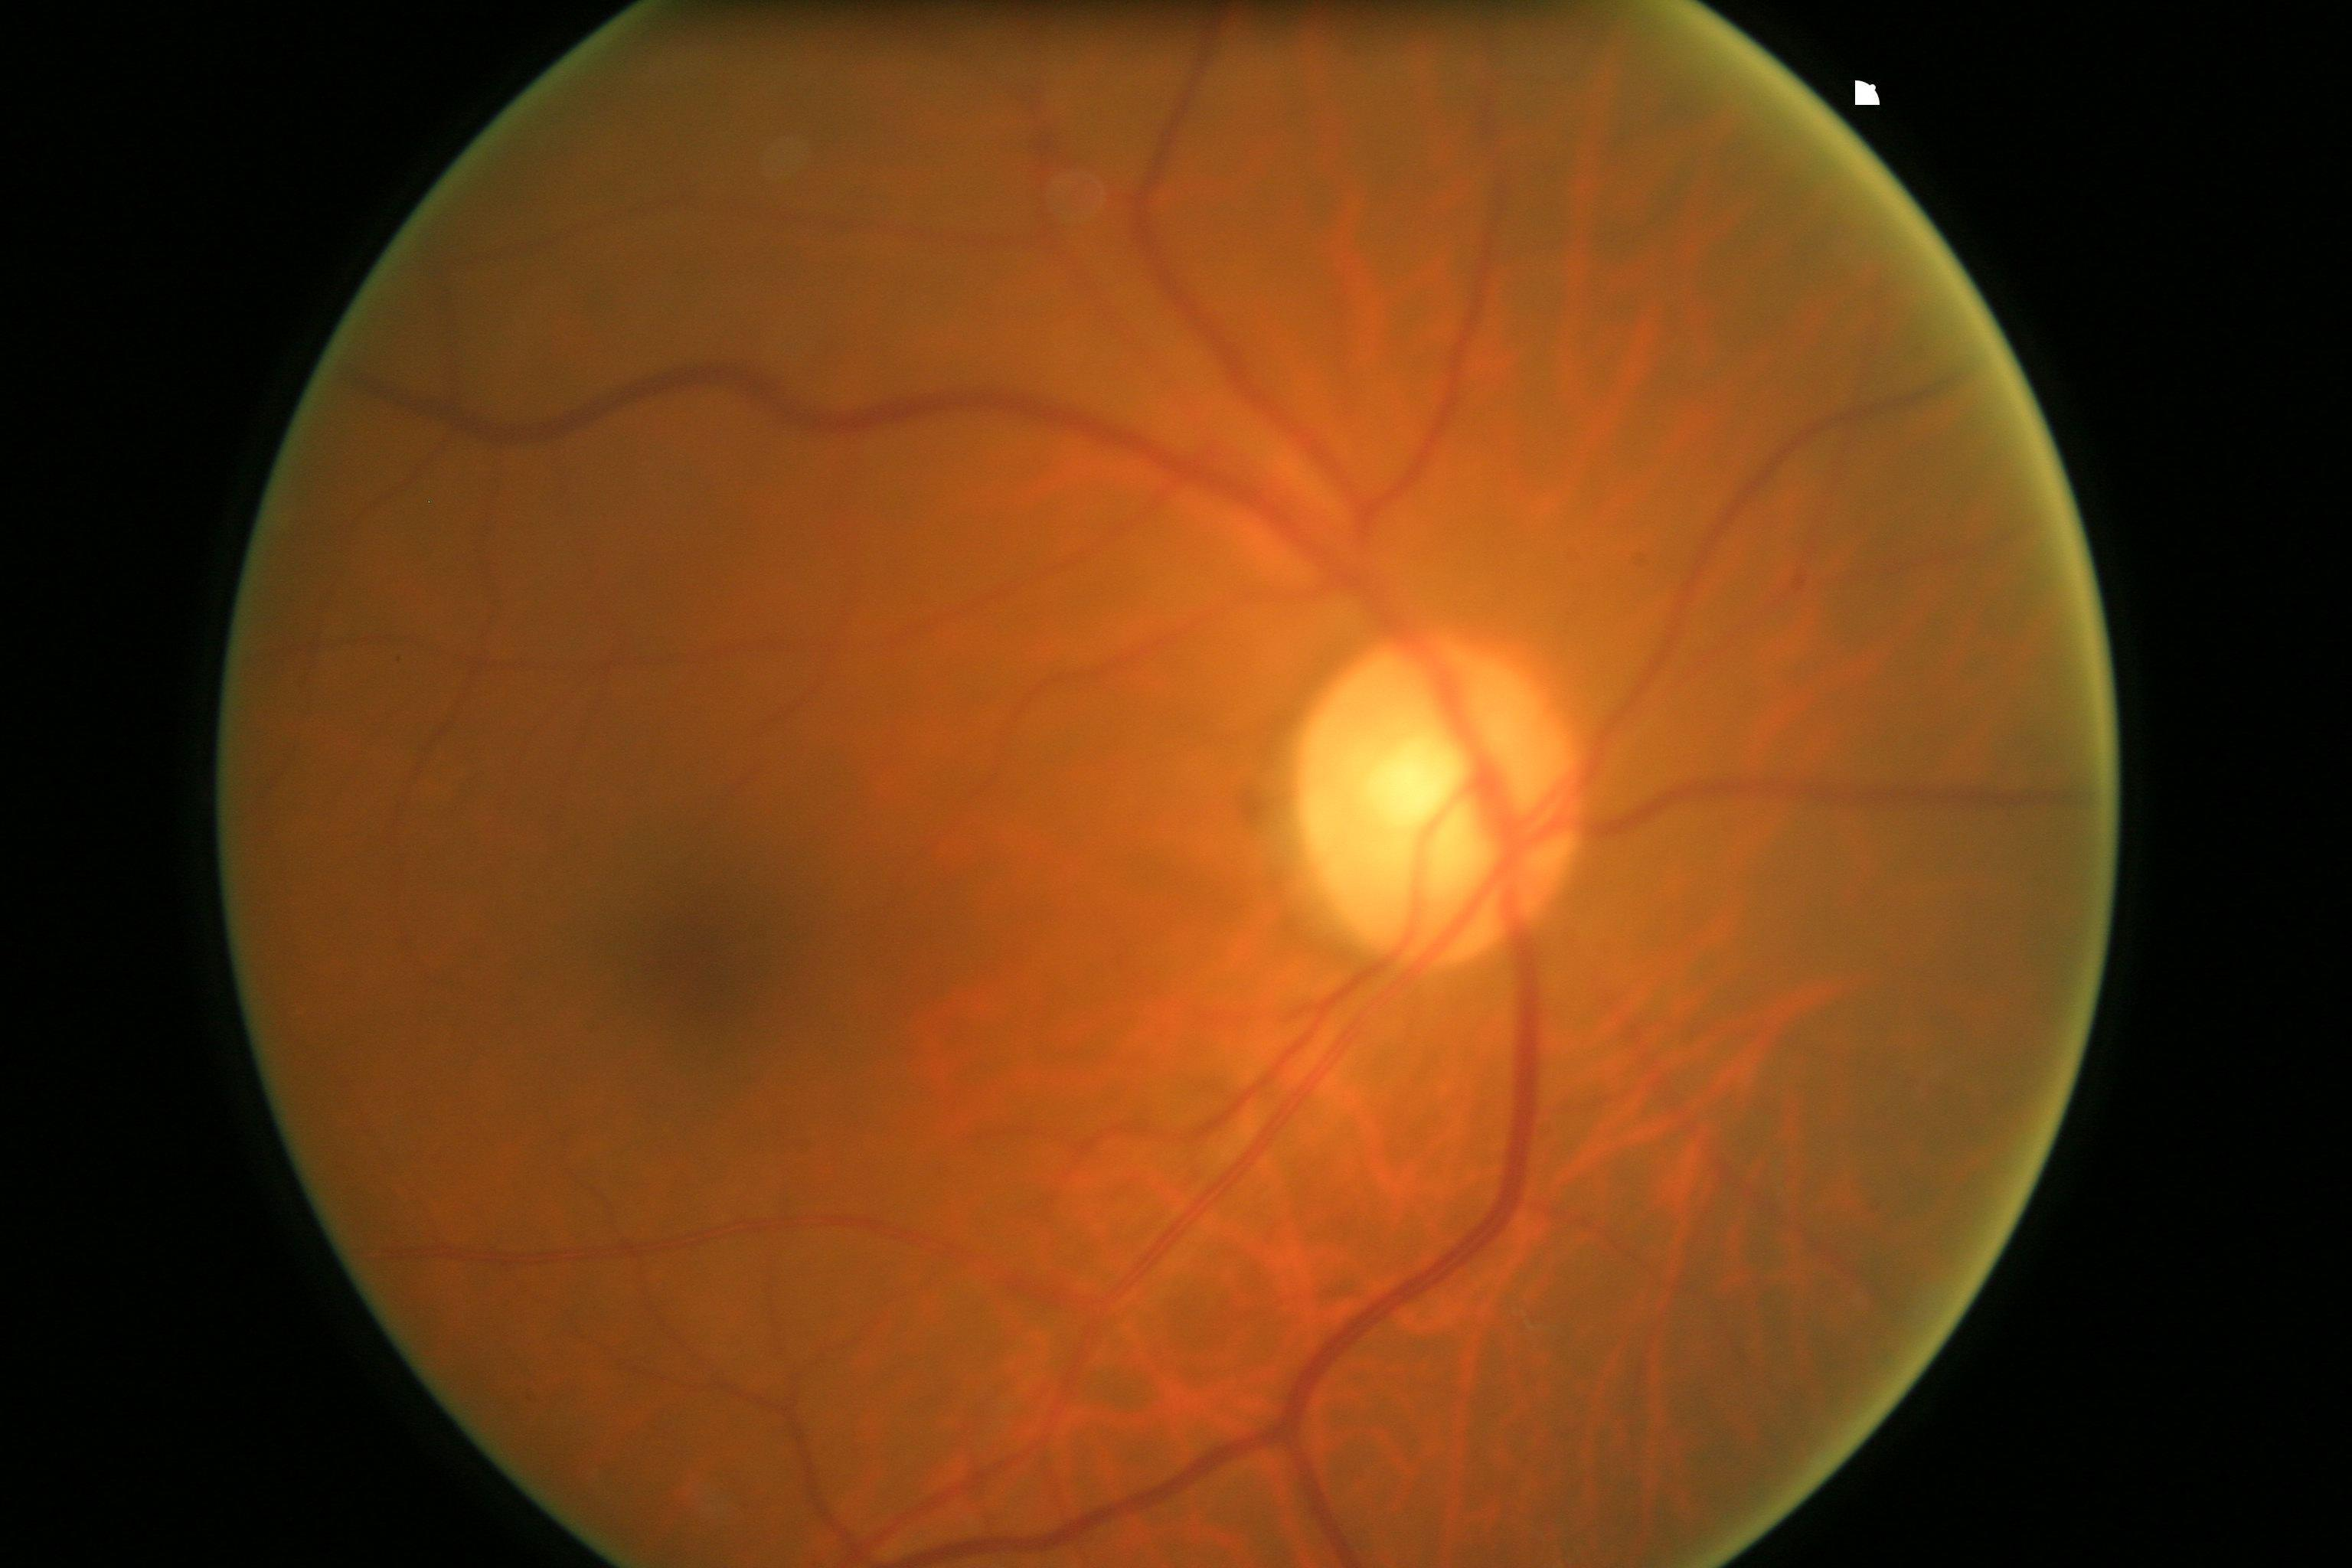

In [7]:
#Import library
from IPython import display
display.Image(filename='./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', width=220, height=150)

In [8]:
# Using one image as example
# calculate image pixel mean, min, max

mean = pixels.mean()
print('Mean: %.3f' % mean)
# confirm pixel range is 0-255
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Mean: 63.332
Min: 0.000, Max: 255.000


In [9]:
import tensorflow as tf
print(tf.__version__) #2.8.2

2.8.2


In [10]:
# global centering similar to minmaxscaler but for images
# using tf.keras.layers.Resizing and tf.keras.layers.Rescaling
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(150,220), # desired height, width
    layers.Rescaling(1./255)
])

result = resize_and_rescale(pixels)

Verify that the pixels are in the [0, 1] range:

In [11]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


## Visualisation

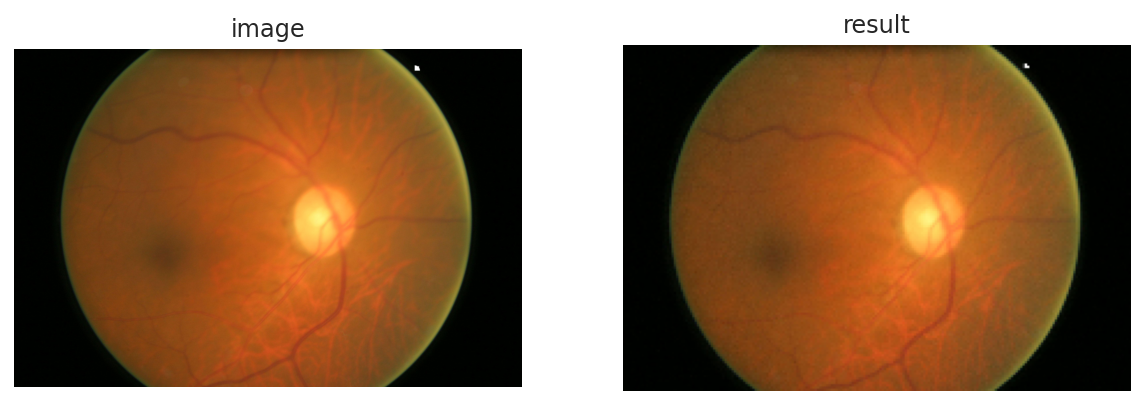

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,8))
ax0.imshow(im)
ax0.axis('off')
ax0.set_title('image')
# after pixel normalisation
ax1.imshow(result)
ax1.axis('off')
ax1.set_title('result')
plt.show() # result seems to have slight blurring of image, but still have good distinction of optic disc

## Image labelling

In [13]:
# generate dataset that can be used for machine learning
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (150, 220) # scaled for model
batch_size = 32

train_ds = image_dataset_from_directory(
    './GA_Capstone/Fundus_Scans/Train/',
    image_size=image_size,
    labels='inferred',
    label_mode='binary', # binary crossentropy
    shuffle=True,
    seed=1,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    './GA_Capstone/Fundus_Scans/Validation/',
    image_size=image_size,
    labels='inferred',
    label_mode='binary', # binary crossentropy
    shuffle=True,
    seed=1,
    batch_size=batch_size
)

Found 520 files belonging to 2 classes.
Found 130 files belonging to 2 classes.


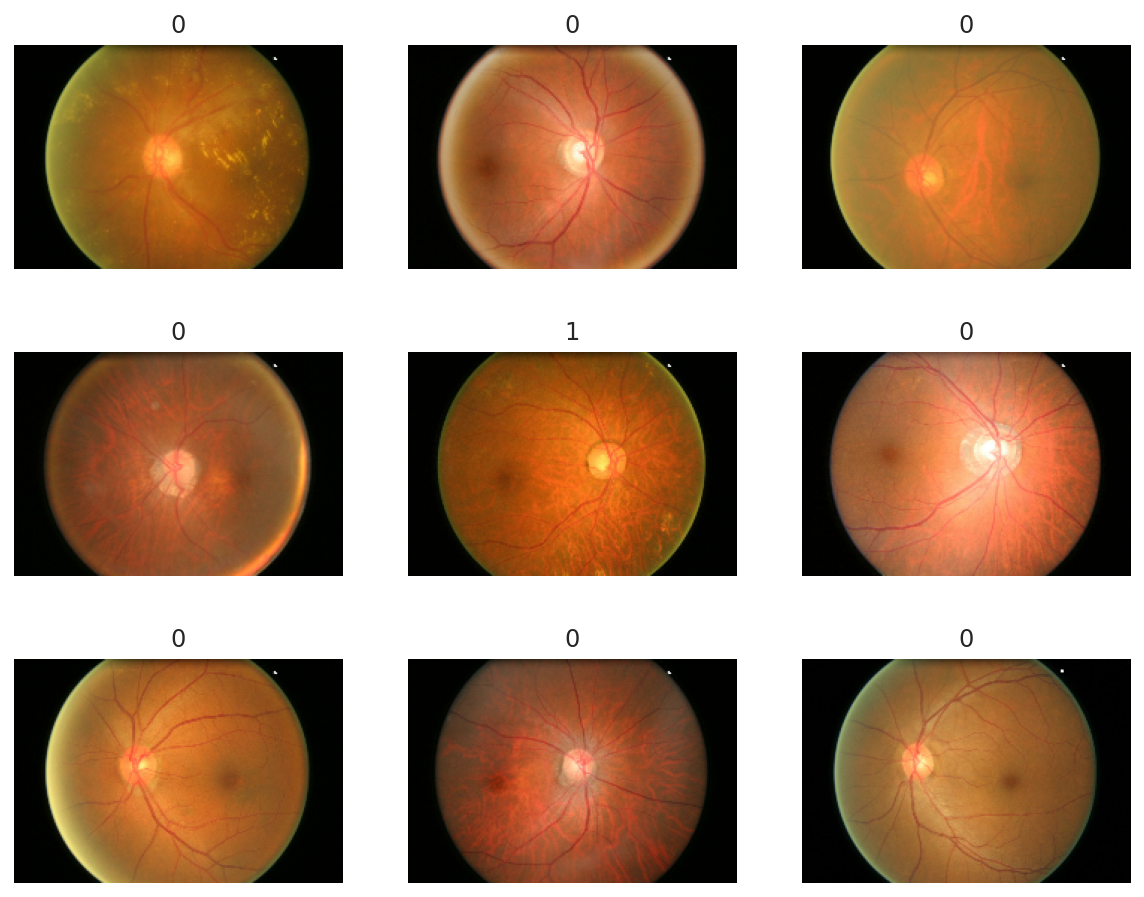

In [14]:
# preview of how images are labelled
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1): # images scaled 150 x 220
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Image data augmentation

__References:__
1. [Keras.io](https://keras.io/examples/vision/image_classification_from_scratch/)
1. [Tensorflow](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [15]:
data_augmentation = tf.keras.Sequential(
    [ layers.RandomFlip("horizontal_and_vertical", seed=42), 
      layers.RandomRotation(0.2, seed=42),
      layers.RandomContrast(0.1, seed=42),
      layers.RandomCrop(height=200, width=200, seed=1)
    ])

Visualize what augmented images look like, applying `data_augmentation` repeatedly to the first image in the train dataset

In [16]:
# preview of how images are augmented
def augmented_ds_imgs():
  plt.figure(figsize=(8, 8))
  for images, _ in train_ds.take(1): 
    for i in range(9):
      augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8")) # output standard 255 x 255
      plt.axis("off")

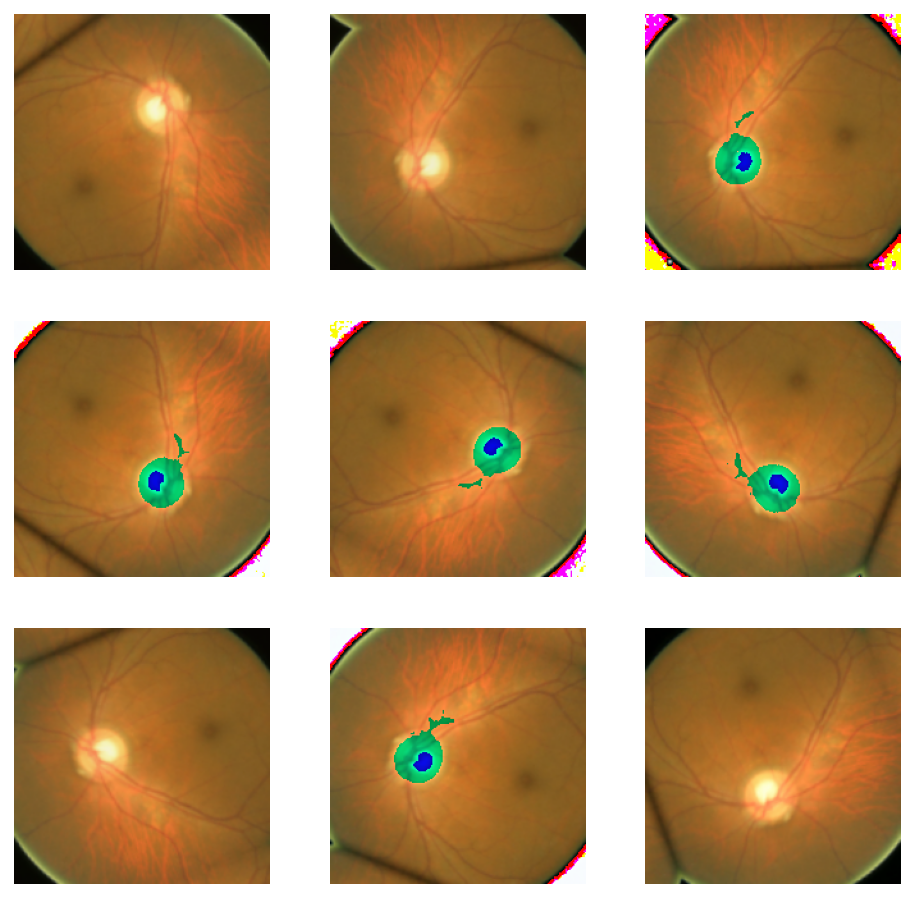

In [17]:
augmented_ds_imgs()

#### Get Contours of image
[Reference](https://pythonexamples.org/python-opencv-cv2-find-contours-in-image/)

In [18]:
# Import the library OpenCV
import cv2
from google.colab.patches import cv2_imshow # to stabilise cv2.imshow() function

def retina_contour():    
  # Read the image
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', -1) # imread_unchanged
  
  # Convert image to grayscale
  img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # generates grayscale image

  # set thresh # this needs guessing for desired contours
  thresh=30
  # get threshold image
  ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
  
  #find contours
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  #create an empty image for contours
  img_contours = np.zeros(img.shape)

  # draw the contours on the empty image
  cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
  
  cv2_imshow(cv2.resize(img_contours, (220, 150), interpolation=cv2.INTER_AREA)) # resize the image for less file space
  #cv2_imshow(img_contours)
  
  # if needed, to save image
  # cv2.imwrite("contours.jpg", img_contours)

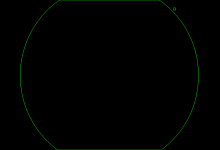

In [19]:
retina_contour()

In [20]:
def disc_contour():    
  # Read the image
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', -1) # imread_unchanged
  
  # Convert image to grayscale
  img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # generates grayscale image

  # set thresh # this needs guessing for desired contours
  thresh=155
  # get threshold image
  ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
  
  #find contours
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  #create an empty image for contours
  img_contours = np.zeros(img.shape)

  # draw the contours on the empty image
  cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
  
  cv2_imshow(cv2.resize(img_contours, (220, 150), interpolation=cv2.INTER_AREA)) # resize the image for less file space
  #cv2_imshow(img_contours)
  
  # if needed, to save image
  # cv2.imwrite("contours.jpg", img_contours)

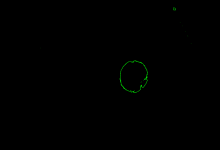

In [21]:
disc_contour()

### Using WaterShed Algorithm to segment out retina from black background

__References:__
1. [OpenCV WaterShed](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html)
2. [GeeksforGeeks](https://www.geeksforgeeks.org/removing-black-background-and-make-transparent-using-python-opencv/)

In [22]:
def mask():
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  cv2_imshow(cv2.resize(thresh, (220, 150), interpolation=cv2.INTER_AREA))
  return thresh

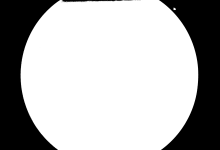

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [23]:
mask()
# black region shows background
# white region shows foreground

In [47]:
def remove_bg():
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, alpha = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  
  b, g, r = cv2.split(img) # Using cv2.split() to split channels
  
  rgba = [b, g, r, alpha] # Making list of Red, Green, Blue channels and alpha

  new_img = cv2.merge(rgba, 4)

  cv2_imshow(cv2.resize(new_img, (220, 150), interpolation=cv2.INTER_AREA))
  # if needed, save image
  cv2.imwrite("./EDA/no_bg.png", new_img) # jpg does not support alpha channel, only png or tiff format
  return new_img

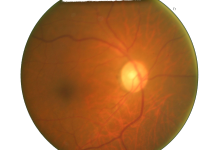

array([[0, 3, 1, 0],
       [0, 3, 1, 0],
       [0, 3, 1, 0],
       ...,
       [0, 3, 1, 0],
       [0, 3, 1, 0],
       [0, 3, 1, 0]], dtype=uint8)

In [48]:
remove_bg()[0] # this image has 4 channels

In [26]:
# try augmentation again
# on removed background image
image2 = cv2.imread('./EDA/no_bg.png', cv2.IMREAD_UNCHANGED)
print(image2.shape) # 4 channels
pixels2 = np.asarray(image2) # show numpy array format

print(pixels2[0])

(2048, 3072, 4)
[[0 3 1 0]
 [0 3 1 0]
 [0 3 1 0]
 ...
 [0 3 1 0]
 [0 3 1 0]
 [0 3 1 0]]


In [49]:
# needs revision
from numpy import expand_dims

image_size = (150, 220) # scaled for model
batch_size = 1 # only 1 image to sample
sample_ds = image_dataset_from_directory(
    './EDA/',
    image_size=image_size,
    batch_size=batch_size
)

def augmented_imgs():
  plt.figure(figsize=(8, 8))
  for image, _ in sample_ds.take(1):
    for i in range(9):
      augmented_image = data_augmentation(image)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0].numpy().astype("uint8")) # output standard 255 x 255
      plt.axis("off")

 # img = tf.io.read_file("./EDA/no_bg.png")
  # print(img.mode) -- RGBA channels
  # convert to tensor
 # tensor = tf.io.decode_image(img, channels=4, dtype=tf.dtypes.float32)
  # resize tensor to 255 x 255
  #tensor = tf.image.resize(tensor, [255, 255])
  # (255, 255, 4)
  # add another dimension at the front to get NHWC shape
  #input_tensor = tf.expand_dims(tensor, axis=0)
  # (1, 255, 255, 4)

FileNotFoundError: ignored

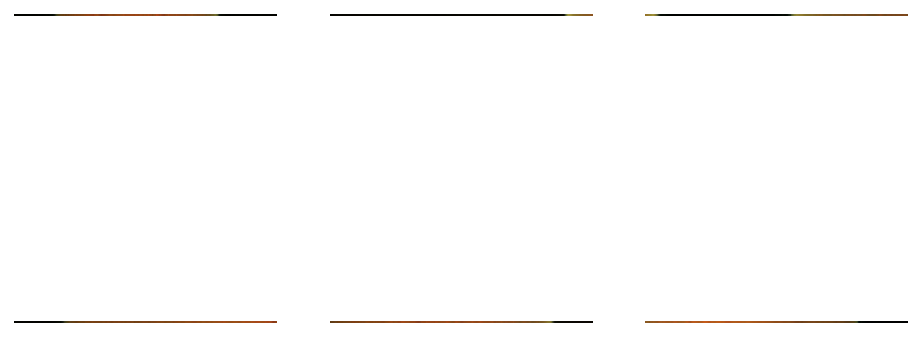

In [46]:
augmented_imgs()

# UNet structure
<img src="https://miro.medium.com/max/1050/1*1Q3ODFV_t2WVXvm_09ExjA.png" width="400" height="250"> 